[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_mistralai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

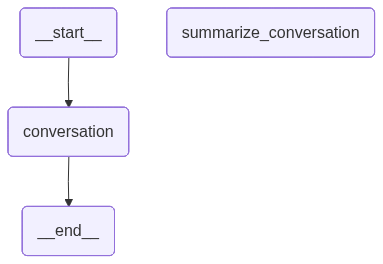

In [2]:
from IPython.display import Image, display

from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM - Using Mistral AI
model = ChatMistralAI(model="mistral-large-latest", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation about John Mayer
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm a huge fan of John Mayer's guitar playing. Can you tell me about his musical style?")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Absolutely! John Mayer is one of the most versatile and influential guitarists of his generation, blending **blues, pop, rock, R&B, and jazz** into a signature style that’s both technically impressive and emotionally expressive. Here’s a breakdown of his musical and guitar-playing style:\n\n---\n\n### **1. Blues Foundation (The Core of His Sound)**\nMayer’s playing is deeply rooted in **electric blues**, particularly the styles of:\n- **B.B. King** (vibrato, phrasing, "less is more" approach)\n- **Stevie Ray Vaughan** (aggressive Texas blues, pentatonic licks)\n- **Albert King** (bending, soulful phrasing)\n- **Freddie King** (punctuated, rhythmic playing)\n- **Jimi Hendrix** (expressive whammy bar use, chordal solos)\n\n**Key Examples:**\n- *"Slow Dancing in a Burning Room"* (SRV-style pentatonic runs)\n- *"Gravity"* (B.B. King-inspired bends and vibrato)\n- *"I Don’t Need No Doctor"* (live covers with Hendrix/Albert King influence)\n\n

Let's now just print the state update.

In [4]:
# Start conversation about John Mayer's albums
for chunk in graph.stream({"messages": [HumanMessage(content="What are some of John Mayer's most influential albums and what makes them special?")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

John Mayer’s discography is a **masterclass in evolution**—from acoustic pop-rock to blues revivalism, jazz-inflected R&B, and back to retro-inspired pop. Each of his **most influential albums** represents a distinct phase in his career, showcasing his growth as a **guitarist, songwriter, and vocalist**. Here’s a breakdown of his **essential albums**, what makes them special, and their lasting impact:

---

### **1. *Room for Squares* (2001) – The Breakthrough**
**Why It’s Influential:**
- Mayer’s **debut major-label album** (after *Inside Wants Out*, 1999) that **launched him into stardom**.
- Blends **acoustic singer-songwriter pop** with **bluesy electric guitar**—a fresh sound in the early 2000s.
- Features **some of his biggest hits**, proving he could write **catchy, radio-friendly songs** with **musical depth**.

**Key Tracks & Why They Matter:**
- **"No Such Thing"** – A **coming-of-age anthem** w

Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation about John Mayer's guitar techniques
input_message = HumanMessage(content="I'd love to learn about John Mayer's signature guitar techniques. What are his most distinctive playing styles?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

I'd love to learn about John Mayer's signature guitar techniques. What are his most distinctive playing styles?
---------------------------------------------------------------------------
================================ Human Message =================================

I'd love to learn about John Mayer's signature guitar techniques. What are his most distinctive playing styles?
================================== Ai Message ==================================

John Mayer is one of the most distinctive modern guitarists, blending blues, pop, funk, and jazz influences into a highly personal style. His playing is marked by **expressive phrasing, hybrid picking, intricate rhythm work, and a deep blues vocabulary**. Here are his **most signature techniques and styles**:

---

### **1. Hybrid Picking (Pick + Fingers)**
Mayer is a master of **hybrid picking**, using a pick for bass notes and his fingers (middle, 

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about John Mayer's most memorable live performances and what makes his concerts so special")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conversation. Type: on_chat_model_stream. Name: ChatMistralAI
Node: conv

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="What are some of John Mayer's most notable collaborations with other artists, and how did they influence his music?")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b-01cf409284bf')}
{'chunk': AIMessageChunk(content='John', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b-01cf409284bf')}
{'chunk': AIMessageChunk(content=' Mayer', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b-01cf409284bf')}
{'chunk': AIMessageChunk(content=' has collaborated', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b-01cf409284bf')}
{'chunk': AIMessageChunk(content=' with a', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b-01cf409284bf')}
{'chunk': AIMessageChunk(content=' wide range', additional_kwargs={}, response_metadata={'model_provider': 'mistralai'}, id='lc_run--42124a2b-213f-4df0-834b

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Analyze John Mayer's songwriting evolution from his early work like 'Room for Squares' to his recent blues-influenced albums")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|John| Mayer|’s song|writing evolution| is| one of the most| fascinating trajectories| in modern popular| music, marked| by| shifts in| genre, lyr|ical depth, and| artistic| ambition| in modern popular| music, marked| by| shifts in| genre, lyr|ical depth, and| artistic| ambition|. From| his| early| pop-rock| breakthrough| in| *Room| for Squares*|. From| his| early| pop-rock| breakthrough| in| *Room| for Squares*| (200|1) to his| blues revival|ism| in *The Search| for| Everything|* (20| (200|1) to his| blues revival|ism| in *The Search| for| Everything|* (20|17) and| *S|ob Rock|* (20|21|), Mayer|’s growth|17) and| *S|ob Rock|* (20|21|), Mayer|’s growth| reflects| both personal| reflects| both personal| maturation| and a| deliberate pursuit| of| musical| authenticity|. Below| is a breakdown of| his evolution| across| four| key| phases:

---

###| **1. The| Pop-Rock| Pro| maturation| and a| deliberate pursuit| of| musical| authenticity|. Below| is a breakdown of| his evolution| across| fo

### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [9]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [10]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [11]:
# Create a new thread
thread = await client.threads.create()
# Input message about John Mayer's guitar gear
input_message = HumanMessage(content="What guitars and equipment does John Mayer use to achieve his signature tone?")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a2649-76af-706e-9843-a7727949b6db', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'What guitars and equipment does John Mayer use to achieve his signature tone?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '8e96cc35-72cb-4239-a003-7ac26a6014f7'}]})
StreamPart(event='error', data={'error': 'HTTPStatusError', 'message': 'Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"object":"error","message":"Service tier capacity exceeded for this model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}'})
StreamPart(event='error', data={'error': 'HTTPStatusError', 'message': 'Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"object":"error","message":"Service tier capacity exceeded for this model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}'})


The streamed objects have: 

* `event`: Type
* `data`: State

In [12]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="How have blues legends like B.B. King and Stevie Ray Vaughan influenced John Mayer's playing style?")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content="How have blues legends like B.B. King and Stevie Ray Vaughan influenced John Mayer's playing style?" additional_kwargs={} response_metadata={} id='a3f45d4a-4511-4dda-a9ee-22258760c8f0'
content='John Mayer\'s guitar playing style is deeply influenced by blues legends like **B.B. King** and **Stevie Ray Vaughan (SRV)**, though his approach blends their techniques with his own modern, melodic sensibilities. Here’s how these icons have shaped Mayer’s style:\n\n---\n\n### **1. B.B. King’s Influence**\nB.B. King was known for his **expressive vibrato, economical note choice, and soulful phrasing**. Mayer has incorporated these elements into his playing in the following ways:\n\n- **Vibrato and Bending**:\n  - B.B. King’s **slow, wide vibrato** and **subtle string bends** are hallmarks of his style. Mayer often emulates this, particularly in slower, bluesy solos (e.g., *"Slow Dancing in a Burning Room"* or *"I Don’t Trust Myself (With Loving You)"*).\n  - Mayer’s bends are **controll

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Describe John Mayer's evolution from pop sensation to respected blues guitarist throughout his career")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mes

We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Tell me about John Mayer's legendary guitar collection, including his vintage Stratocasters and signature PRS guitars")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 019a264a-6e4e-74d1-a149-9ee441915df9
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is not
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is not only renowned
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is not only renowned for his
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is not only renowned for his incredible
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: John Mayer is not only renowned for his incredible guitar playing
Response 